<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_3/Supp_Fig_3d/1_macaque_celltype_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Host cell type assignment

In [ ]:
!pip install -q anndata gget

In [ ]:
import anndata
import numpy as np
import pandas as pd
import json
import os
import gget
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
%load_ext blackcellmagic

import scanpy as sc
# sc.set_figure_params(figsize=(6, 6), frameon=False)
# sc.settings.n_jobs=2

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

Sat Nov 18 13:50:50 2023 INFO Generating grammar tables from /home/laura/anaconda3/lib/python3.9/site-packages/blib2to3/Grammar.txt
Sat Nov 18 13:50:50 2023 INFO Writing grammar tables to /home/laura/.cache/black/21.12b0/Grammar3.9.12.final.0.pickle
Sat Nov 18 13:50:50 2023 INFO Writing failed: [Errno 2] No such file or directory: '/home/laura/.cache/black/21.12b0/tmpg3h5o6_d'
Sat Nov 18 13:50:50 2023 INFO Generating grammar tables from /home/laura/anaconda3/lib/python3.9/site-packages/blib2to3/PatternGrammar.txt
Sat Nov 18 13:50:50 2023 INFO Writing grammar tables to /home/laura/.cache/black/21.12b0/PatternGrammar3.9.12.final.0.pickle
Sat Nov 18 13:50:50 2023 INFO Writing failed: [Errno 2] No such file or directory: '/home/laura/.cache/black/21.12b0/tmpcee8v23u'


___
# Load data

The count matrix was generated in [this notebook](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_3/Supp_Fig_3abc/2_host_normalization_clustering.ipynb).

In [ ]:
# Load filtered, normalized and clustered macaque count matrix from Caltech Data
# !wget

In [ ]:
host_adata = anndata.read("macaque_QC_norm_leiden.h5ad")
host_adata

AnnData object with n_obs × n_vars = 202525 × 66553
    obs: 'sample_barcode', 'barcode', 'srr', 'n_counts', 'n_genes', 'percent_mito', 'species', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden'
    var: 'gene_id', 'species', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

___
# Load marker genes

In [ ]:
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_3/Supp_Fig_3d/marker_genes.csv
marker_df = pd.read_csv("marker_genes.csv")

In [ ]:
# Get Ensembl IDs from gene symbols using gget
search_results = gget.search(marker_df["gene_symbol"].values, species="macaca_mulatta", release=109)
# Filter gget results for exact matches and protein-coding biotypes
search_results_filtered = search_results[search_results["gene_name"].isin(marker_df["gene_symbol"].values)][search_results["biotype"]=="protein_coding"]

Thu Jul 13 19:04:27 2023 INFO Fetching results from database: macaca_mulatta_core_109_10
Thu Jul 13 19:04:43 2023 INFO Total matches found: 64.
Thu Jul 13 19:04:43 2023 INFO Query time: 21.34 seconds.


In [ ]:
# Add Ensembl IDs to marker gene df
marker_df["ensembl_id"] = np.NaN

ensembl_id_list = []

for i, gene_symbol in enumerate(marker_df["gene_symbol"].values):
    ensembl_ids = search_results_filtered[
        search_results_filtered["gene_name"] == gene_symbol
    ]["ensembl_id"].values

    if len(ensembl_ids) < 1:
        if gene_symbol.startswith("ENS"):
            ensembl_id_list.append([gene_symbol])
        else:
            print(f"An Ensembl ID for gene {gene_symbol} could not be found.")

    else:
        ensembl_id_list.append(ensembl_ids)

marker_df["ensembl_id_list"] = ensembl_id_list
marker_df["ensembl_id"] = [id_list[0] for id_list in ensembl_id_list]
marker_df

,celltype,gene_name,gene_symbol,ensembl_id,ensembl_id_list
0,B cells,MS4A1,MS4A1,ENSMMUG00000001260,[ENSMMUG00000001260]
1,B cells,CD19,CD19,ENSMMUG00000006880,[ENSMMUG00000006880]
2,B cells,CD79B,CD79B,ENSMMUG00000041327,[ENSMMUG00000041327]
3,Dendritic cells,IRF8,IRF8,ENSMMUG00000008125,[ENSMMUG00000008125]
4,Dendritic cells,CD1C,CD1C,ENSMMUG00000010626,[ENSMMUG00000010626]
5,Panleukocyte,CD45,PTPRC,ENSMMUG00000000009,[ENSMMUG00000000009]
6,Monocytes,FCGR3,ENSMMUG00000016206,ENSMMUG00000016206,[ENSMMUG00000016206]
7,Monocytes,HLA-DRB5,HLA-DRB5,ENSMMUG00000029799,[ENSMMUG00000029799]
8,Monocytes,HLA-DRA,HLA-DRA,ENSMMUG00000039082,[ENSMMUG00000039082]
9,Monocytes,CD68,CD68,ENSMMUG00000013501,[ENSMMUG00000013501]


___

In [ ]:
def flatten(xss):
    """
    Function to flatten array of arrays.
    """
    return [x for xs in xss for x in xs]

Add gene names of marker genes to adata:

In [ ]:
host_adata.var["gene_symbol"] = [np.NaN] * len(host_adata.var)

for ensembl_id, gene_symbol in zip(marker_df["ensembl_id"].values, marker_df["gene_name"].values):
    host_adata.var.loc[host_adata.var.index == ensembl_id, "gene_symbol"] = gene_symbol

In [ ]:
host_adata.var[~host_adata.var['gene_symbol'].isnull()]

,gene_id,species,highly_variable,means,dispersions,dispersions_norm,gene_symbol
ensembl_id,,,,,,,
ENSMMUG00000016206,ENSMMUG00000016206.4,macaca_mulatta,True,1.178563,3.522391,3.196381,FCGR3
ENSMMUG00000010626,ENSMMUG00000010626.4,macaca_mulatta,True,1.314157,3.275508,1.936864,CD1C
ENSMMUG00000000009,ENSMMUG00000000009.4,macaca_mulatta,False,3.167732,3.095801,-0.463718,CD45
ENSMMUG00000029799,ENSMMUG00000029799.3,macaca_mulatta,True,2.639786,3.686318,0.744780,HLA-DRB5
ENSMMUG00000039082,ENSMMUG00000039082.2,macaca_mulatta,False,3.322802,4.138247,2.542198,HLA-DRA
ENSMMUG00000050418,ENSMMUG00000050418.1,macaca_mulatta,True,2.136736,4.482270,3.204547,SOD2
ENSMMUG00000044429,ENSMMUG00000044429.2,macaca_mulatta,True,0.023625,2.991160,0.743518,GYPA
ENSMMUG00000001676,ENSMMUG00000001676.4,macaca_mulatta,True,2.170944,3.511412,0.982493,IL7R
ENSMMUG00000058774,ENSMMUG00000058774.1,macaca_mulatta,True,0.250966,3.154348,1.165858,MZB1


Plot marker gene expression per group:

In [ ]:
celltypes = ['T cells', 'B cells', 'Plasmablast', 'Natural killer cells', 'Dendritic cells', 'Immature neutrophils', 'Monocytes', 'Panleukocyte', 'Cytokines', 'Proliferation']

# Grab markers in order of celltypes
markers = []
x_labels = []
for celltype in celltypes:
    markers = markers + list(marker_df.iloc[marker_df.index[marker_df['celltype'] == celltype].tolist()]["ensembl_id"].values)
    x_labels = x_labels + list(marker_df.iloc[marker_df.index[marker_df['celltype'] == celltype].tolist()]["gene_name"].values)

In [ ]:
var_groups = []
start = 0
for celltype in celltypes:
    c_indeces = marker_df.index[marker_df["celltype"] == celltype].tolist()
    var_groups.append((start, start+(c_indeces[-1] - c_indeces[0])))
    start = start+(c_indeces[-1] - c_indeces[0]) + 1

... storing 'gene_symbol' as categorical


categories: 0, 1, 2, etc.
var_group_labels: , , , etc.


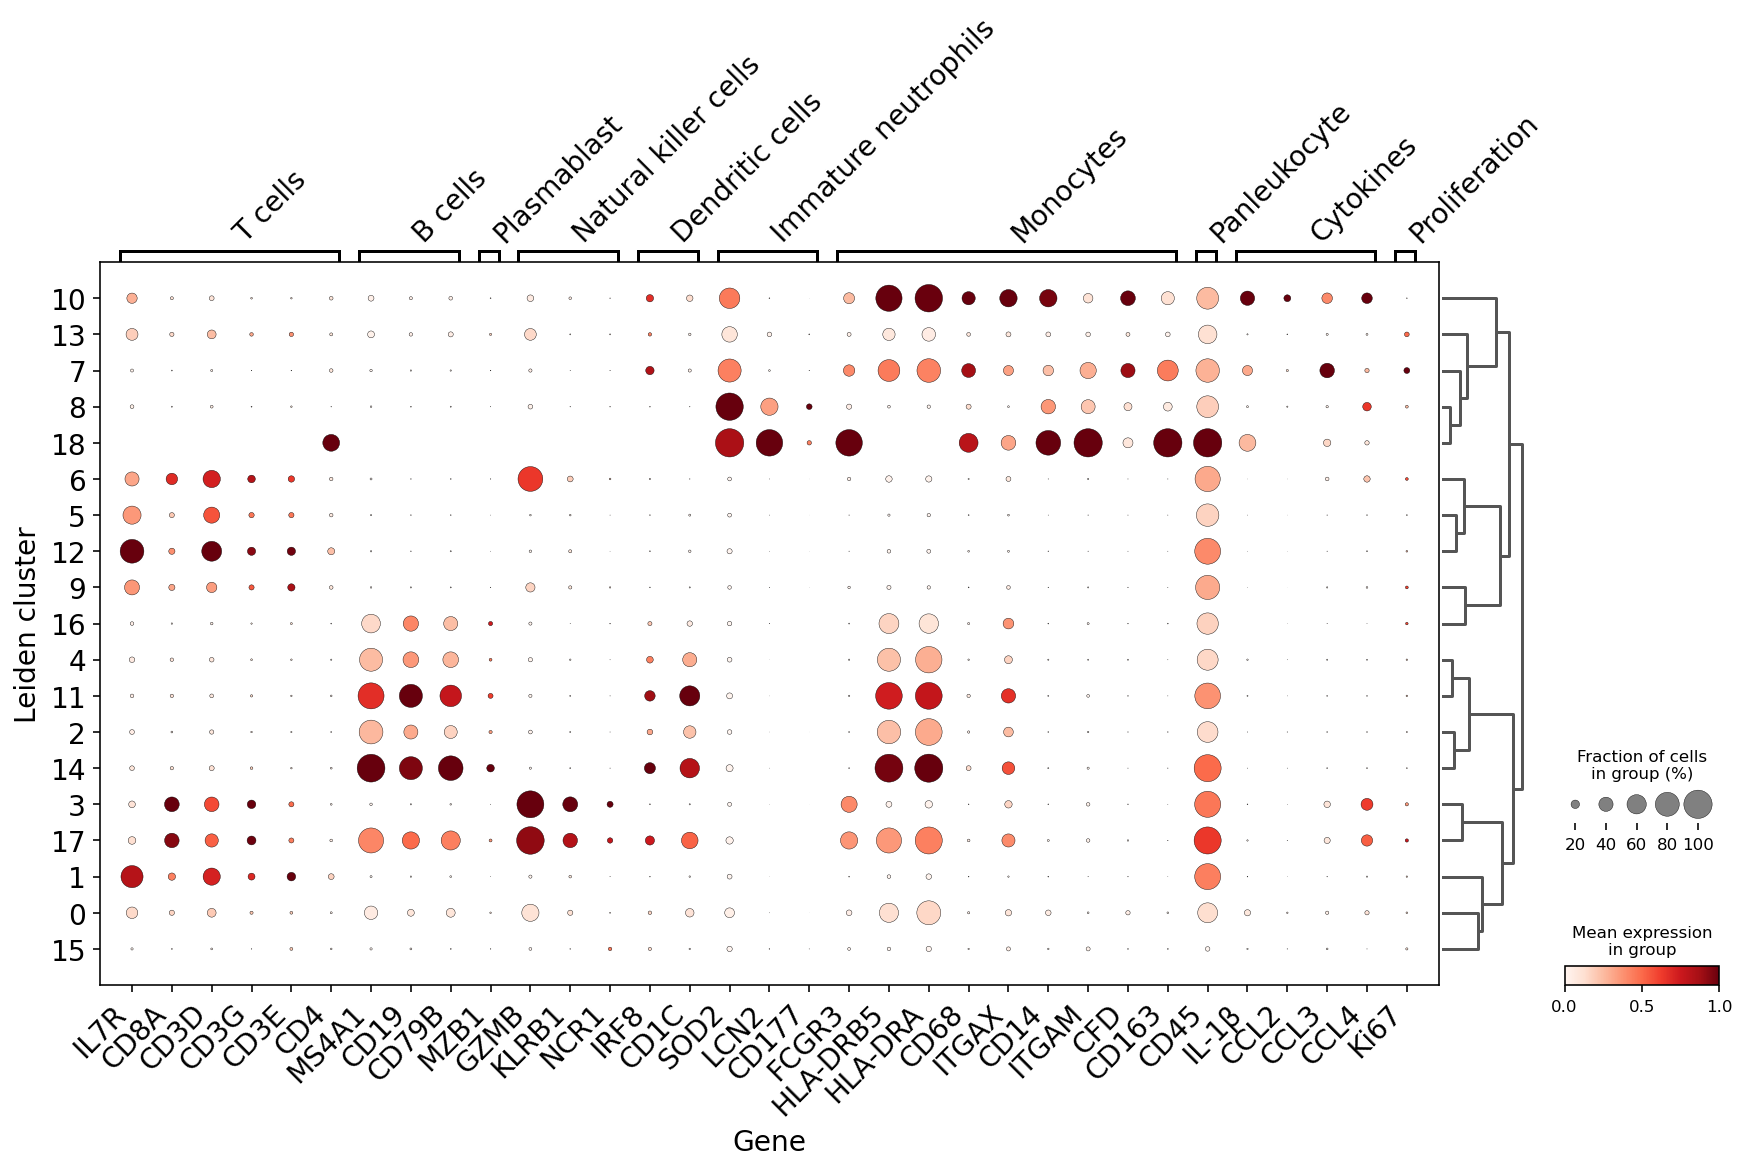

In [ ]:
fontsize = 14

temp_var_labels = [""] * len(celltypes)

ax = sc.pl.dotplot(
    host_adata,
    markers,
    groupby="leiden",
    use_raw=True,
    dendrogram=True,
    var_group_positions=var_groups,
    var_group_labels=temp_var_labels,
    var_group_rotation=45,
    swap_axes=False,
    standard_scale="var",
    show=False,
)

# ax["mainplot_ax"].set_title(f"Expression of marker genes in {'-'.join(adata.obs['tissue'][0].split('/'))} dataset", pad=120)

## Rotate var labels
# Get initial label positions from: ax["gene_group_ax"].properties()["children"]
var_positions = [2.95, 7.449999999999999, 9.45, 11.45, 13.95, 16.45, 22.45, 27.45, 29.95, 32.45]
for position, label in zip(var_positions, celltypes):
    ax["gene_group_ax"].text(position, 1.1, label, fontsize=fontsize, rotation=45, ha="left")

ax["mainplot_ax"].set_xticklabels(x_labels, rotation=45, ha="right", fontsize=fontsize)
ax["mainplot_ax"].set_xlabel("Gene", fontsize=fontsize)

ax["mainplot_ax"].set_ylabel("Leiden cluster", fontsize=fontsize)

ax["mainplot_ax"].tick_params(axis="both", labelsize=fontsize)

plt.tight_layout()

# # Save plot
# plt.savefig(f"host_leiden_marker-gene-expression.png", dpi=300, bbox_inches="tight")

Define celltypes:

In [ ]:
df_celltypes = pd.DataFrame()
df_celltypes["cluster"] = np.arange(19)
df_celltypes["celltype"] = [
    "B cells 4",
    "T cells 2",
    "B cells 6",
    "Natural killer 1",
    "B cells 2",
    "T cells 4",
    "T cells 5",
    "Monocytes 2",
    "Immature neutrophils 1",
    "T cells 1",
    "Monocytes 1",
    "B cells 1",
    "T cells 3",
    "Undefined 2",
    "B cells 5",
    "Undefined 3",
    "B cells 7",
    "B cells 3",
    "Undefined 1",
]

df_celltypes

,cluster,celltype
0,0,B cells 4
1,1,T cells 2
2,2,B cells 6
3,3,Natural killer 1
4,4,B cells 2
5,5,T cells 4
6,6,T cells 5
7,7,Monocytes 2
8,8,Immature neutrophils 1
9,9,T cells 1


In [ ]:
# Create copy of leiden cluster column to store manually assigned celltypes
host_adata.obs["celltype_clusters"] = host_adata.obs.leiden.copy()

# Relabel the clusters in celltype
host_adata.rename_categories("celltype_clusters", df_celltypes["celltype"].values)

# Sort celltype labels using categorical data type
celltype_order = [
    "B cells 1",
    "B cells 2",
    "B cells 3",
    "B cells 4",
    "B cells 5",
    "B cells 6",
    "B cells 7",
    "T cells 1",
    "T cells 2",
    "T cells 3",
    "T cells 4",
    "T cells 5",
    "Natural killer 1",
    "Monocytes 1",
    "Monocytes 2",
    "Immature neutrophils 1",
    "Undefined 1",
    "Undefined 2",
    "Undefined 3"
]
host_adata.obs["celltype_clusters"] = host_adata.obs["celltype_clusters"].cat.reorder_categories(list(celltype_order))

/home/laura/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Create merged celltype column:

In [ ]:
host_adata.obs["celltype"] = [" ".join(i.split(" ")[:-1]) for i in host_adata.obs["celltype_clusters"]]

Merge timpeoints 7d and 8d due to few counts (also done in the original paper):

In [ ]:
new_tps = []
for tp in host_adata.obs["dpi_clean"].values:
    if tp == "7d" or tp == "8d":
        new_tps.append("7d/8d")
    else:
        new_tps.append(tp)

host_adata.obs["dpi_clean_merged"] = new_tps

___
Save host count matrix with celltype assignments:

In [ ]:
host_adata.write("macaque_QC_norm_leiden_celltypes.h5ad")

... storing 'celltype' as categorical
... storing 'dpi_clean_merged' as categorical
